In [23]:
!uv add pandas scikit-learn seaborn

⠸ exceptiongroup==1.3.1                                                         Resolved 146 packages in 478ms
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnickm Preparing packages... (0/0)                                                   
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovski/repos/uni/dnick
⠙ Preparing packages... (0/3)
   Building traffic-predictions @ file:///Users/viktorhristovs

In [221]:
import pandas as pd 
from sklearn.cluster import KMeans,AgglomerativeClustering
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [12]:
df=pd.read_csv("../data/avtopati.csv")
df.sample(2)

,RB,R_NUMBER,S_NUMBER,S_NAME,Datum,LENGTH SECTION,Ave_Rain,Max_Snow,Ave_Temp,Max_Temp,...,Wi 2014,Wi 2015,Wi 2016,Wi 2017,Wi 2018,Wi 2019,Wi 2020,Wi 2021,Wi 2022,Wi 2023
154,155,A4,9154,Preod (avtopat) - Sveti Nikole S (avtopat),2019,6883,587,9.01,13.01,31.41,...,0.00,0.000,0.0,0.000,0.000,0.000,0.000,0.000,1.453,0.000
24,25,A2,58,Grupchin (avtopat) - Zhelino 1 (avtopat),2013,7917,626,13.95,12.15,30.24,...,28.42,6.316,0.0,1.263,2.526,6.316,25.894,17.683,7.579,3.789


In [16]:
df1 = df.iloc[:, -10:]
df1.sample(2)

,Wi 2014,Wi 2015,Wi 2016,Wi 2017,Wi 2018,Wi 2019,Wi 2020,Wi 2021,Wi 2022,Wi 2023
17,6.812,12.943,4.087,0.0,0.000,0.0,1.362,2.725,2.725,28.61
51,11.050,11.050,58.011,0.0,5.525,0.0,5.525,22.099,0.000,0.00


In [17]:
df1.columns = [
    col.split(' ')[1]
    for col in df1.columns 
]
df1.columns

Index(['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

In [18]:
df1.sample(2)

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
76,9.106,6.071,16.044,19.946,14.309,6.938,18.645,12.575,18.212,9.973
145,0.000,2.174,3.261,0.000,5.435,2.174,1.087,2.174,3.261,6.522


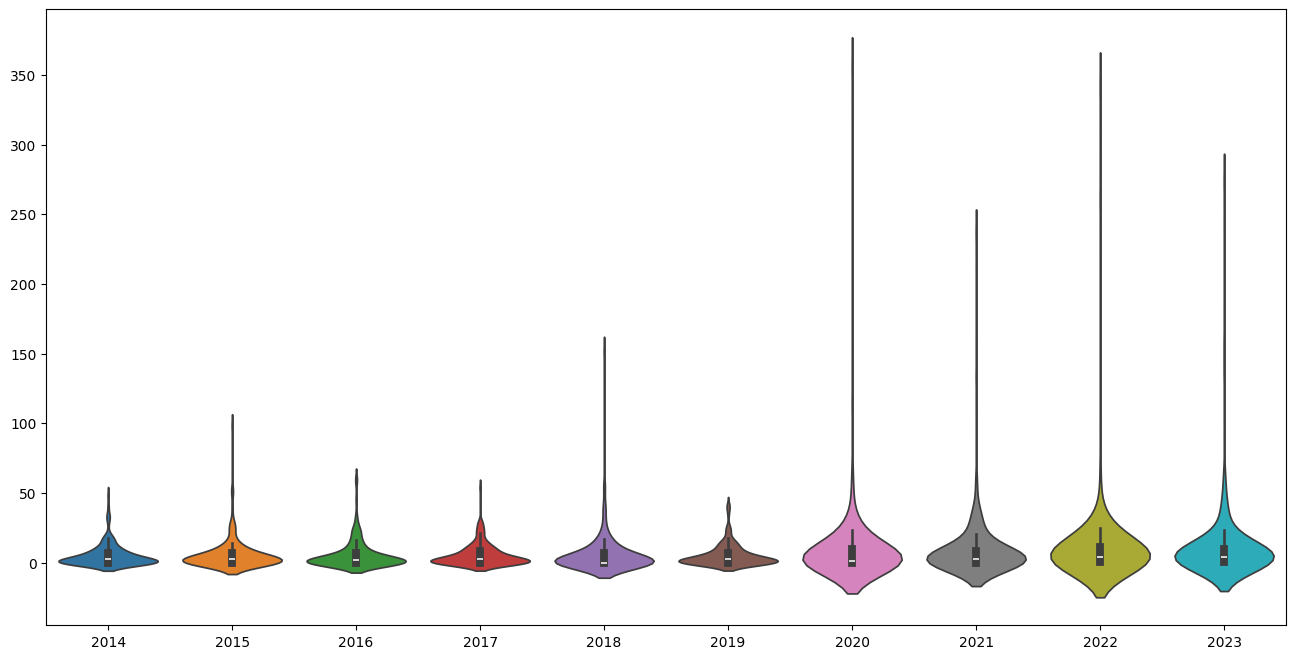

In [27]:
plt.figure(figsize=(16,8))
sns.violinplot(data=df1)
plt.show()

In [ ]:
from sklearn.base import TransformerMixin

def cluster_data(df:pd.DataFrame, scaller:TransformerMixin, model) -> dict:
    df_scalled = scaller.fit_transform(df) 
    model.fit(df_scalled)
    results =  model.labels_.astype(int) if hasattr(model, "labels_") else model.predict(df_scalled)
    return { 
        "silhouette" : silhouette_score(df_scalled,results),
        "calinski" : calinski_harabasz_score(df_scalled, results),
        "davies_bouldin": davies_bouldin_score(df_scalled,results),
        "preds" : results
    }

In [195]:
def clean_results(results:dict)->dict:
    return {score_name : score_val for score_name,score_val in results.items() if score_name != 'preds'}

# Clustering based on average of years

In [207]:
df3=df1.mean(axis=1)
df3

0      2.2069
1      1.1464
2      9.3694
3      2.4643
4      3.3465
        ...  
156    0.1154
157    0.8492
158    3.7046
159    5.5376
160    4.8273
Length: 161, dtype: float64

In [208]:
results = {} 

In [209]:
cluster_results=cluster_data(df3.to_frame(),StandardScaler(),KMeans(n_clusters=5))
results['KMeans'] = { 
    "preds" : cluster_results['preds'],
    "eval" : clean_results(cluster_results)
}

In [210]:
linkages=['ward', 'complete', 'average', 'single']
for linkage in linkages:
    agglomerative_results = cluster_data(df3.to_frame(), StandardScaler(), AgglomerativeClustering(n_clusters=5,linkage=linkage))
    results[linkage] = { 
        "preds" : agglomerative_results['preds'],
        'eval' : clean_results(agglomerative_results)
    }

In [211]:
model_preds = { 
    model : model_summary['preds'] for model,model_summary in results.items() 
}
df_results = pd.DataFrame({
    model : model_summary['eval'] for model,model_summary in results.items()
})
df_results = df_results.transpose()

In [212]:
df_results

,silhouette,calinski,davies_bouldin
KMeans,0.552617,976.582952,0.347680
ward,0.532810,902.798114,0.336658
complete,0.602860,829.029083,0.302026
average,0.620139,643.365286,0.230512
single,0.617474,226.547139,0.208216


From the results we can conlude that complete clustering is the best one, because of the highest value for silhouete and calinski. 

## Making a model form complete linkage 

In [213]:
model_preds['complete']

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 3, 0, 0, 1, 0, 1, 4, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 4, 0, 0, 1, 1, 1, 1, 4, 1, 4, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [218]:
df_model = pd.concat([
    df3,
    pd.Series(model_preds['complete'])
],axis=1)
df_model.columns = ['Average Index', 'Group']
df_model

,Average Index,Group
0,2.2069,1
1,1.1464,1
2,9.3694,0
3,2.4643,1
4,3.3465,1
...,...,...
156,0.1154,1
157,0.8492,1
158,3.7046,1
159,5.5376,1


In [219]:
df_model['Group'].value_counts()

Group
1    110
0     42
4      7
2      1
3      1
Name: count, dtype: int64

In [225]:
scaler = StandardScaler()

X = df_model.drop(columns=['Group'])
X_scalled = scaler.fit_transform(X)
y = df_model['Group']

X_train, X_temp, y_train, y_temp = train_test_split(X_scalled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

k_values=range(3,12)
results = {
   i : {"f1": 0, "recall" : 0, "accuracy" : 0} for i in k_values
}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    results[k] = { 
        "f1" : f1_score(y_val, y_pred, average='weighted'),
        "recall": recall_score(y_val, y_pred, average='weighted'),
        "accuracy": accuracy_score(y_val, y_pred)
    }

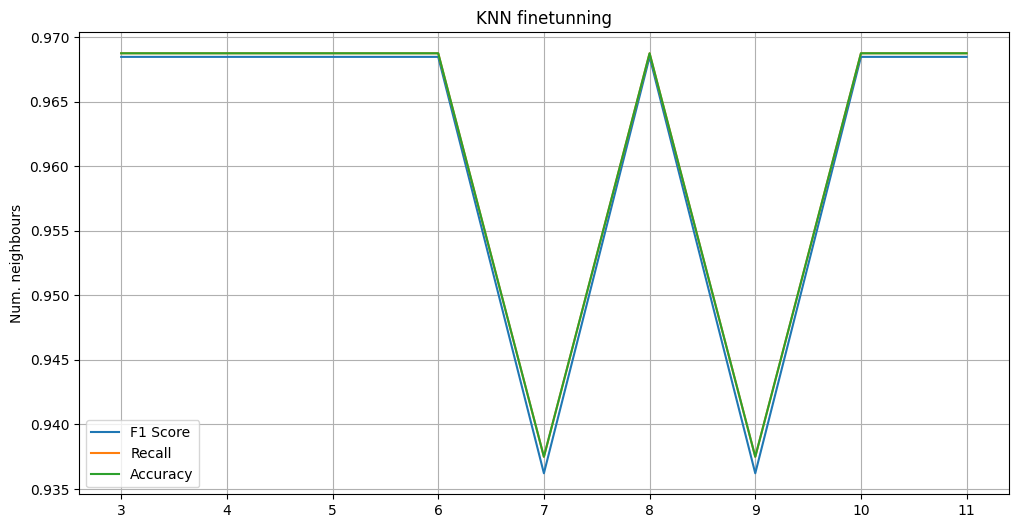

In [230]:
f1=[results[k]['f1'] for k in k_values]
recall=[results[k]['recall'] for k in k_values]
accuracy=[results[k]['accuracy'] for k in k_values]

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.xticks(k_values)

plt.title("KNN finetunning")
plt.ylabel("Num. neighbours")

plt.plot(k_values, f1, label='F1 Score')
plt.plot(k_values, recall, label='Recall')
plt.plot(k_values, accuracy, label='Accuracy')

plt.legend()
plt.show()

We can conclude that for about every value for k in the interval [3,6] the model gives the same results, which are okey. We will pick 3 as our K in KNN.

# Mapping groups to IRAP categories